# Comparing sigma calculations
- This notebook loads simulated tritium and gamma clusters and compares the sigma calculations between the classical and mlccd_diffusion methods.

### Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import mlccd_models
%load_ext autoreload
%autoreload 2

2024-11-08 10:14:48.029461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 10:14:48.045523: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 10:14:48.050455: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 10:14:48.062193: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-08 10:14:48.738012: W tensorflow/compiler/tf2

### Load CCDData and add classical variables to metadata

In [2]:
data_base_path = os.path.expanduser("~/data/CCD_data/")
data_tritium = mlccd_models.CCDData(os.path.join(data_base_path,"Simulated_training_clusters/2024-10-17-tritium-and-gamma-100keV-more-realistic-diffusion/diffused_H3_5000000.h5"),image_unit="keV")
clusters_tritium = mlccd_models.add_cluster_metadata(data_tritium)

In [3]:
data_gamma = mlccd_models.CCDData(os.path.join(data_base_path,"Simulated_training_clusters/2024-10-17-tritium-and-gamma-100keV-more-realistic-diffusion/diffused_gamma_70000000.h5"),image_unit="keV")
clusters_gamma = mlccd_models.add_cluster_metadata(data_gamma)


### Calculate sigma using mlccd_diffusion

In [19]:
import mlccd_diffusion
noise_level = mlccd_diffusion.fermilab_noise_level(unit='keV')
threshold = 4 * noise_level
sigma_x, sigma_y, energy = mlccd_diffusion.cluster_sigma(data_tritium.images[:,:,:,0], threshold=threshold, min_pixels_in_cluster=0)

### Compare sigmas between the two methods

Text(0, 0.5, 'Number of clusters')

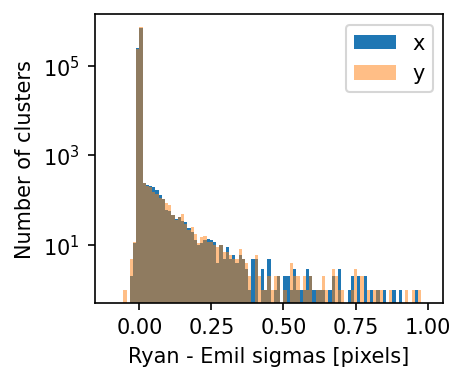

In [23]:
fig, ax = plt.subplots(figsize=(3,2.5), dpi=150)
bins = np.linspace(-0.1,1,100)
difference_x = data_tritium.tracks_metadata["clusterSigmaX"].values - sigma_x
_ = ax.hist(difference_x, bins=bins)   
ax.set_yscale("log")
difference_y = data_tritium.tracks_metadata["clusterSigmaY"].values - sigma_y
_ = ax.hist(difference_y, bins=bins, alpha=0.5)
ax.set_yscale("log")
ax.set_xlabel("Ryan - Emil sigmas [pixels]")
ax.legend(["x", "y"])
ax.set_ylabel("Number of clusters")

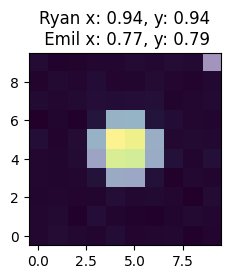

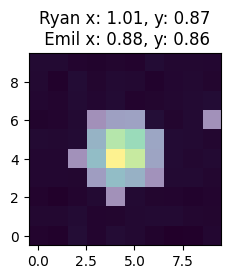

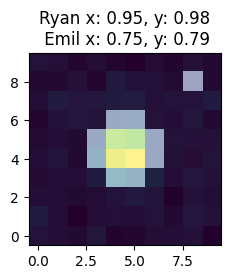

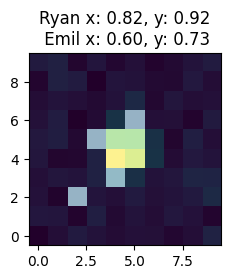

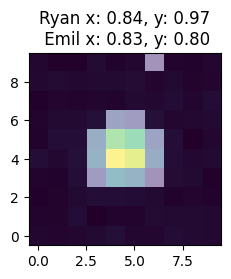

In [24]:
# Select the large difference clusters
threshold_diff = 0.1  # Define a threshold_diff for large differences
large_diff_indices_x = np.where(np.abs(difference_x) > threshold_diff)[0]
large_diff_indices_y = np.where(np.abs(difference_y) > threshold_diff)[0]

# Combine indices for both conditions
large_diff_indices = np.unique(np.concatenate((large_diff_indices_x, large_diff_indices_y)))

# Plot images for large differences
for index in large_diff_indices[:5]:  # Limit to first 5 for clarity
    plt.figure(figsize=(3,2.5), dpi=100)
    # Create a mask for pixels below the threshold
    mask = data_tritium.images[index,:,:,0] < threshold
    # Plot the image
    plt.imshow(data_tritium.images[index,:,:,0].transpose(), origin='lower')
    # Overlay the masked pixels
    plt.imshow(mask.transpose(), cmap='Greys', alpha=0.5, origin='lower')
    plt.title(f'Ryan x: {data_tritium.tracks_metadata.iloc[index]["clusterSigmaX"]:.2f}, y: {data_tritium.tracks_metadata.iloc[index]["clusterSigmaY"]:.2f}\n Emil x: {sigma_x[index]:.2f}, y: {sigma_y[index]:.2f}')

### Conclusion
- `classical_analysis` accidentally includes stray pixels in the sigma calculation.